# Predictive Analysis using Deep Learning
We aim to predict the future prices of Agricultural Commodity using Deep Neural Networks

## Importing Libraries


In [1]:
# Importing the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.optimizers import Adam
from keras.metrics import mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


## Loading the Data

In [2]:
# Loading the data
bengaluru_df = pd.read_csv('preprocessed_krama_report_bengaluru.csv')
doddaballapur_df = pd.read_csv('preprocessed_krama_report_doddaballapur.csv')
hubballi_df = pd.read_csv('preprocessed_krama_report_hubballi.csv')
mysuru_df = pd.read_csv('preprocessed_krama_report_mysuru.csv')

all_df = [bengaluru_df, doddaballapur_df, hubballi_df, mysuru_df]

bengaluru_df.head()

,Min,Max,Modal,Year,Month,Day,Variety_BELLARY RED,Variety_LOCAL,Variety_ONION,Variety_OTHER,Variety_PUNA,Grade_FAQ,Grade_LARGE,Grade_MEDIUM,Grade_SMALL
0,260.0,360.0,310.0,2002.0,2.0,7.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,150.0,240.0,195.0,2002.0,2.0,7.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,170.0,280.0,225.0,2002.0,3.0,27.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,190.0,300.0,245.0,2002.0,3.0,28.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,180.0,280.0,230.0,2002.0,3.0,30.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


## Test-Train Split

In [3]:
X = bengaluru_df.drop(columns=['Min', 'Max', 'Modal'])
Y = bengaluru_df[['Min', 'Max', 'Modal']]

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=50)
input_size = x_train.shape[1]
input_size, x_train.shape, x_test.shape, y_train.shape, y_test.shape

(12, (13034, 12), (3259, 12), (13034, 3), (3259, 3))

## Defining a Simple Model

In [4]:
# Defining the model
def build_simple_dnn_model(input_shape):
    model = models.Sequential()

    # Input layer
    model.add(layers.InputLayer(input_shape=input_shape))

    # Hidden layers
    model.add(layers.Dense(input_shape[0] * 2, activation='relu'))
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(5, activation='relu'))
    
    # Output layer with 3 units (min, max, modal)
    model.add(layers.Dense(3, activation='linear'))  # Linear activation for regression output
    
    # Compile the model
    model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])
    
    return model

## Simple Model Structure

In [5]:
input_shape = (input_size,)

simple_model = build_simple_dnn_model(input_shape)
simple_model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 24)                312       
                                                                 
 dense_1 (Dense)             (None, 10)                250       
                                                                 
 dense_2 (Dense)             (None, 5)                 55        
                                                                 
 dense_3 (Dense)             (None, 3)                 18        
                                                                 
Total params: 635 (2.48 KB)
Trainable params: 635 (2.48 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Simple Model Training and Evaluation

In [6]:
history = simple_model.fit(x_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

loss, mse, mae = simple_model.evaluate(x_test, y_test, verbose=0)
print('Mean Squared Error:', mse)
print('Mean Absolute Error:', mae)


Epoch 1/100


326/326 [==============================] - 5s 5ms/step - loss: 919657.2500 - mse: 919657.2500 - mae: 714.3538 - val_loss: 613414.8125 - val_mse: 613414.8125 - val_mae: 588.6705
Epoch 2/100
326/326 [==============================] - 1s 4ms/step - loss: 499963.5625 - mse: 499963.5625 - mae: 541.1196 - val_loss: 476620.7500 - val_mse: 476620.7500 - val_mae: 536.9270
Epoch 3/100
326/326 [==============================] - 1s 4ms/step - loss: 466611.8750 - mse: 466611.8750 - mae: 529.1060 - val_loss: 476251.1250 - val_mse: 476251.1250 - val_mae: 534.9439
Epoch 4/100
326/326 [==============================] - 1s 4ms/step - loss: 466236.3125 - mse: 466236.3125 - mae: 528.5652 - val_loss: 475617.4062 - val_mse: 475617.4062 - val_mae: 538.2438
Epoch 5/100
326/326 [==============================] - 1s 4ms/step - loss: 465955.9062 - mse: 465955.9062 - mae: 528.6917 - val_loss: 475345.8125 - val_mse: 475345.8125 - val_mae: 539.6479
Epoch 6/100
326/326 [==============================] 

We can see that the model is not performing well. We will try to improve the model by adding more layers and increasing the number of neurons in each layer.

## Defining a Complex Model

In [7]:
def build_advanced_dnn(input_shape):
    model = models.Sequential()

    # Input Layer
    model.add(layers.InputLayer(input_shape=input_shape))

    # Hidden Layers with Dropout and Batch Normalization
    hidden_layer_dropout = 0.7
    
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.BatchNormalization())    # Batch Normalization
    model.add(layers.Dropout(hidden_layer_dropout))            # Dropout
    
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.BatchNormalization())    # Batch Normalization
    model.add(layers.Dropout(hidden_layer_dropout))            # Dropout
    
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.BatchNormalization())    # Batch Normalization
    model.add(layers.Dropout(hidden_layer_dropout))            # Dropout

    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(hidden_layer_dropout))

    model.add(layers.Dense(64, activation='relu'))
    
    # Output Layer for 3 outputs (min, max, modal prices)
    model.add(layers.Dense(3, activation='linear'))  # Linear for regression
    
    # Compile the model with Adam optimizer using learning rate decay
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=0.001, decay_steps=10000, decay_rate=0.9)
    )
    
    model.compile(optimizer=optimizer, loss='mse', metrics=['mse', 'mae'])
    
    return model

## Complex Model Structure

In [8]:
complex_model = build_advanced_dnn(input_shape)
complex_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               1664      
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 128)               16512     
                                                                 
 batch_normalization_1 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 128)              

## Complex Model Training and Evaluation

In [9]:
# Callbacks: Early stopping and ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
# Early stopping to prevent overfitting

# Training
history = complex_model.fit(x_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=1)

# Evaluation
loss, mse, mae = complex_model.evaluate(x_test, y_test, verbose=0)
print('Mean Squared Error:', mse)
print('Mean Absolute Error:', mae)

Epoch 1/100
326/326 [==============================] - 7s 9ms/step - loss: 1272308.6250 - mse: 1272308.6250 - mae: 908.9971 - val_loss: 7151444.5000 - val_mse: 7151444.5000 - val_mae: 2599.2588
Epoch 2/100
326/326 [==============================] - 3s 8ms/step - loss: 455570.7812 - mse: 455570.7812 - mae: 517.9197 - val_loss: 983988.0000 - val_mse: 983988.0000 - val_mae: 752.6423
Epoch 3/100
326/326 [==============================] - 4s 11ms/step - loss: 402327.7812 - mse: 402327.7812 - mae: 478.5411 - val_loss: 999654.3750 - val_mse: 999654.3750 - val_mae: 770.7830
Epoch 4/100
326/326 [==============================] - 3s 10ms/step - loss: 396071.9375 - mse: 396071.9375 - mae: 472.0371 - val_loss: 25935736.0000 - val_mse: 25935736.0000 - val_mae: 4976.1929
Epoch 5/100
326/326 [==============================] - 3s 9ms/step - loss: 385572.1250 - mse: 385572.1250 - mae: 464.0982 - val_loss: 41539400.0000 - val_mse: 41539400.0000 - val_mae: 6352.1392
Epoch 6/100
326/326 [=================

The Training ended at epoch 34 due to early stopping callback. The model is performing similar to the simple model even after adding more layers and neurons.

## Save the Models

In [10]:
import pickle

# Save the simple model
simple_model.save('DL_models/simple_model.keras')

# Save the complex model
complex_model.save('DL_models/complex_model.keras')

## Comparing all Models
We will compare the performance of the ML models and DL models to see which model is performing better.

In [11]:
import pickle

# Load the ml model and dl models
ml_best_min_model = pickle.load(open('ML_models/best_min_model.pkl', 'rb'))
ml_best_max_model = pickle.load(open('ML_models/best_max_model.pkl', 'rb'))
ml_best_modal_model = pickle.load(open('ML_models/best_modal_model.pkl', 'rb'))

simple_model = keras.models.load_model('DL_models/simple_model.keras')
complex_model = keras.models.load_model('DL_models/complex_model.keras')

# Predictions
def predict_ml(df):
    min_price = ml_best_min_model.predict(df)
    max_price = ml_best_max_model.predict(df)
    modal_price = ml_best_modal_model.predict(df)
    
    return pd.DataFrame({'Min': min_price, 'Max': max_price, 'Modal': modal_price})

# Comparision of ML and DL models
def compare_models(x, y):
    ml_predictions = predict_ml(x)
    simple_predictions = simple_model.predict(x)
    complex_predictions = complex_model.predict(x)
    
    ml_mse = np.mean(mean_squared_error(y, ml_predictions))
    simple_mse = np.mean(mean_squared_error(y, simple_predictions))
    complex_mse = np.mean(mean_squared_error(y, complex_predictions))
    
    return ml_mse, simple_mse, complex_mse

# we will use x_test and y_test for comparison
ml_mse, simple_mse, complex_mse = compare_models(x_test, y_test)

# Displaying the results
print('ML Model MSE:', ml_mse)
print('Simple DNN Model MSE:', simple_mse)
print('Complex DNN Model MSE:', complex_mse)


102/102 [==============================] - 1s 3ms/step
ML Model MSE: 5098.656937575145
Simple DNN Model MSE: 326744.56
Complex DNN Model MSE: 350507.9


In [32]:
# Plotting the results

results = {
    'y_test': y_test.to_numpy(),
    'ML Predictions': predict_ml(x_test).to_numpy(),
    'Simple DNN Predictions': simple_model.predict(x_test),
    'Complex DNN Predictions': complex_model.predict(x_test)
}

def find_abs_errors(y_true, y_pred):
    return np.abs(y_true - y_pred)

def find_squared_errors(y_true, y_pred):
    return np.square(y_true - y_pred)

def plot_error_distribution(array1, array2, model=None):
    abs_errors = find_abs_errors(array1, array2)
    abs_errors_clean = abs_errors[~np.isnan(abs_errors) & ~np.isinf(abs_errors)]
    
    labels = ['Min', 'Max', 'Modal']
    sns.histplot(abs_errors_clean, bins=50, kde=True, log_scale=True)
    plt.title('Absolute Errors Distribution for {model} Model'.format(model=model))
    plt.xlabel('Absolute Errors')
    plt.ylabel('Frequency')
    plt.legend(labels)
    plt.show()



102/102 [==============================] - 0s 3ms/step


## Error Distribution in Log Scale

c:\Users\Thej Venkat\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


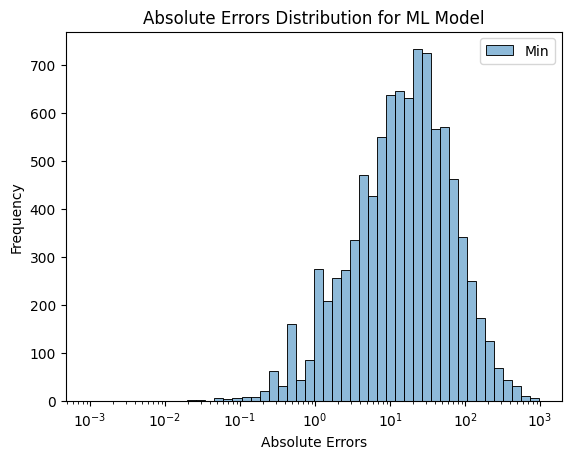

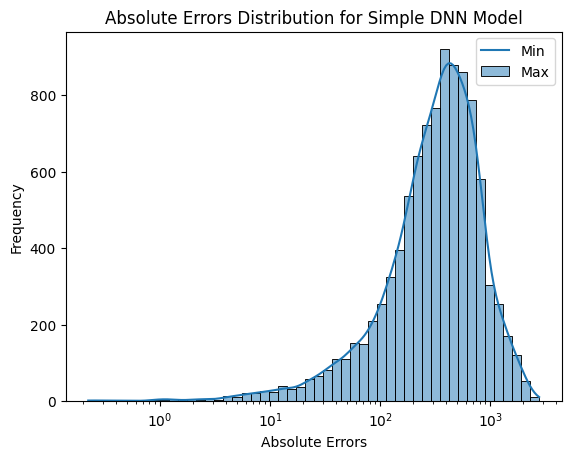

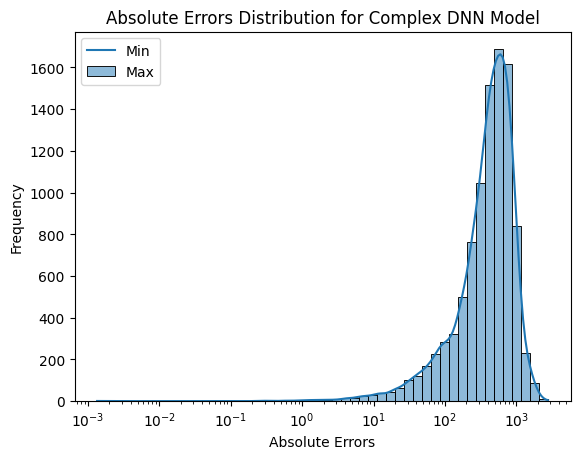

In [33]:
# Plotting the error distribution
plot_error_distribution(results['y_test'], results['ML Predictions'], model='ML')
plot_error_distribution(results['y_test'], results['Simple DNN Predictions'], model='Simple DNN')
plot_error_distribution(results['y_test'], results['Complex DNN Predictions'], model='Complex DNN')

## Overall MAE and RMSE for each Model

C:\Users\Thej Venkat\AppData\Local\Temp\ipykernel_4940\37664693.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.columns, y=results_df.loc['MAE'], palette=['red', 'blue', 'green'])


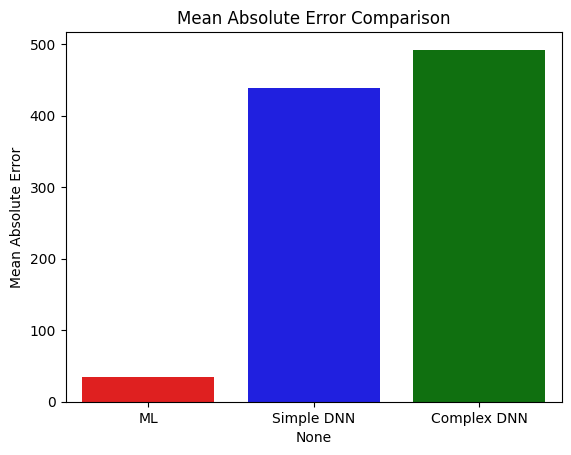

C:\Users\Thej Venkat\AppData\Local\Temp\ipykernel_4940\37664693.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.columns, y=results_df.loc['RMSE'], palette=['red', 'blue', 'green'])


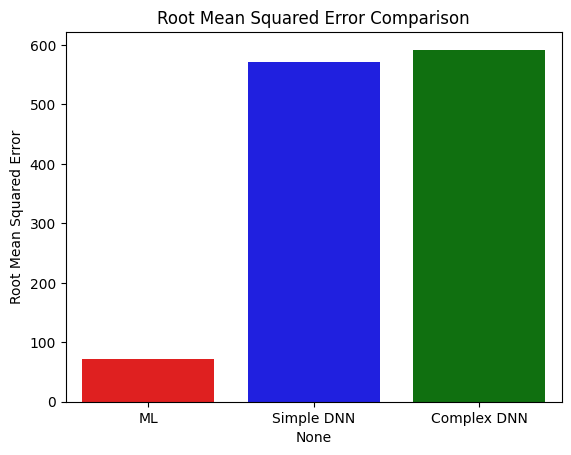

In [36]:
# MAE and RMSE for ML and DL models
metric_results = {}

def find_mae_rmse(y_true, y_pred, model):
    mae = np.mean(find_abs_errors(y_true, y_pred))
    rmse = np.sqrt(np.mean(find_squared_errors(y_true, y_pred)))
    
    metric_results[model] = {
        'MAE': mae,
        'RMSE': rmse
    }

find_mae_rmse(results['y_test'], results['ML Predictions'], 'ML')
find_mae_rmse(results['y_test'], results['Simple DNN Predictions'], 'Simple DNN')
find_mae_rmse(results['y_test'], results['Complex DNN Predictions'], 'Complex DNN')

results_df = pd.DataFrame(metric_results)

sns.barplot(x=results_df.columns, y=results_df.loc['MAE'], palette=['red', 'blue', 'green'])
plt.title('Mean Absolute Error Comparison')
plt.ylabel('Mean Absolute Error')
plt.show()

sns.barplot(x=results_df.columns, y=results_df.loc['RMSE'], palette=['red', 'blue', 'green'])
plt.title('Root Mean Squared Error Comparison')
plt.ylabel('Root Mean Squared Error')
plt.show()
    

## Conclusion
We can see that despite the complexity of the Deep Learning models, they are performing worse than the Machine Learning model. This could be due to the small dataset and the simple structure of the data with few features. We can try to improve the performance of the models by adding more features and increasing the dataset size.

Currently, the Machine Learning model is performing better than the Deep Learning models, so we can use the Machine Learning model for predicting the future prices of Agricultural Commodity.